In [1]:
from covid.common import SparkSessionService

In [2]:
workspace_path = "COVID-DATABRICKS"
database_path = f"/{workspace_path}/.data"
spark_session_service = SparkSessionService()
spark = spark_session_service.get_spark_session()

:: loading settings :: url = jar:file:/opt/conda/envs/pyspark/lib/python3.10/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
io.delta#delta-core_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-ec617f2d-573e-40fc-b6ba-5f12164bc352;1.0
	confs: [default]
	found io.delta#delta-core_2.12;2.4.0 in central
	found io.delta#delta-storage;2.4.0 in central
	found org.antlr#antlr4-runtime;4.9.3 in central
:: resolution report :: resolve 339ms :: artifacts dl 27ms
	:: modules in use:
	io.delta#delta-core_2.12;2.4.0 from central in [default]
	io.delta#delta-storage;2.4.0 from central in [default]
	org.antlr#antlr4-runtime;4.9.3 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   3   |   0   |   0   |   0 

In [3]:
from covid.common import read_delta

bronze_path = f"{database_path}/bronze/covid"
df = read_delta(spark, bronze_path)

In [4]:
df.columns

['regiao',
 'estado',
 'municipio',
 'coduf',
 'codmun',
 'codRegiaoSaude',
 'nomeRegiaoSaude',
 'data',
 'semanaEpi',
 'populacaoTCU2019',
 'casosAcumulado',
 'casosNovos',
 'obitosAcumulado',
 'obitosNovos',
 'Recuperadosnovos',
 'emAcompanhamentoNovos',
 'interior/metropolitana']

In [5]:
from covid.silver import drop_columns

df = drop_columns(df)

In [6]:
df.columns

['regiao',
 'estado',
 'municipio',
 'coduf',
 'codmun',
 'codRegiaoSaude',
 'nomeRegiaoSaude',
 'data',
 'semanaEpi',
 'populacaoTCU2019',
 'casosAcumulado',
 'casosNovos',
 'obitosAcumulado',
 'obitosNovos',
 'interior/metropolitana']

In [7]:
from covid.silver import rename_columns

df = rename_columns(df)
df.columns

['regiao',
 'estado',
 'municipio',
 'coduf',
 'codmun',
 'cod_regiao_saude',
 'nome_regiao_saude',
 'data',
 'semana_epi',
 'populacao_tcu_2019',
 'casos_acumulados',
 'casos_novos',
 'obitos_acumulados',
 'obitos_novos',
 'interior_metropolitana']

In [8]:
from covid.silver import add_date_features

df = add_date_features(df)
df.printSchema()

root
 |-- regiao: string (nullable = true)
 |-- estado: string (nullable = true)
 |-- municipio: string (nullable = true)
 |-- coduf: integer (nullable = true)
 |-- codmun: integer (nullable = true)
 |-- cod_regiao_saude: integer (nullable = true)
 |-- nome_regiao_saude: string (nullable = true)
 |-- data: date (nullable = true)
 |-- semana_epi: integer (nullable = true)
 |-- populacao_tcu_2019: integer (nullable = true)
 |-- casos_acumulados: double (nullable = true)
 |-- casos_novos: integer (nullable = true)
 |-- obitos_acumulados: integer (nullable = true)
 |-- obitos_novos: integer (nullable = true)
 |-- interior_metropolitana: integer (nullable = true)
 |-- ano: integer (nullable = true)
 |-- mes: string (nullable = true)
 |-- mes_numerico: integer (nullable = true)
 |-- mes_traduzido: string (nullable = true)
 |-- dia_semana: string (nullable = true)
 |-- dia_semana_traduzido: string (nullable = true)
 |-- dia_semana_numerico: integer (nullable = true)
 |-- estacao: string (null

In [9]:
import pyspark.sql.functions as F

rio_df = df.where((F.col("municipio") == ("Rio de Janeiro")) & (F.col("data") < "2020-08-01"))

rio_df.show(10)

25/11/17 19:45:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------+--------------+-----+------+----------------+-----------------+----------+----------+------------------+----------------+-----------+-----------------+------------+----------------------+----+-----+------------+-------------+----------+--------------------+-------------------+-------+
| regiao|estado|     municipio|coduf|codmun|cod_regiao_saude|nome_regiao_saude|      data|semana_epi|populacao_tcu_2019|casos_acumulados|casos_novos|obitos_acumulados|obitos_novos|interior_metropolitana| ano|  mes|mes_numerico|mes_traduzido|dia_semana|dia_semana_traduzido|dia_semana_numerico|estacao|
+-------+------+--------------+-----+------+----------------+-----------------+----------+----------+------------------+----------------+-----------+-----------------+------------+----------------------+----+-----+------------+-------------+----------+--------------------+-------------------+-------+
|Sudeste|    RJ|Rio de Janeiro|   33|330455|           33005|  METROPOLITANA I|2020-03-27|    

In [16]:
import matplotlib.dates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


def plot(df_spark, label=""):
    df = df_spark.toPandas()
    plt.figure(figsize=(20, 5))
    df["data"] = pd.to_datetime(df["data"])
    plt.title(label)
    sns.lineplot(data=df, y="casos_novos", x="data")

    # Set major ticks every 3 months
    plt.gca().xaxis.set_major_locator(matplotlib.dates.MonthLocator(interval=1))

    # Format the date labels
    plt.gca().xaxis.set_major_formatter(matplotlib.dates.DateFormatter("%B %Y"))

    # plt.xticks(rotation=90)
    plt.xlabel("")
    plt.ylabel("Casos novos", {"size": 14})

    plt.tick_params(axis="both", labelsize=14)

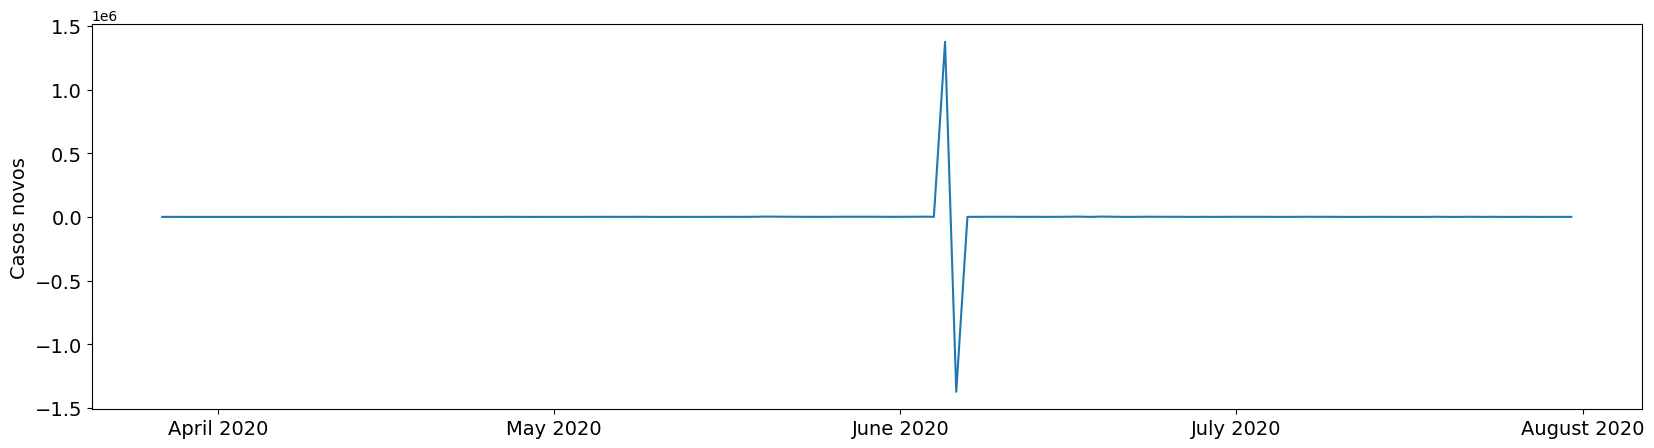

In [17]:
plot(rio_df)

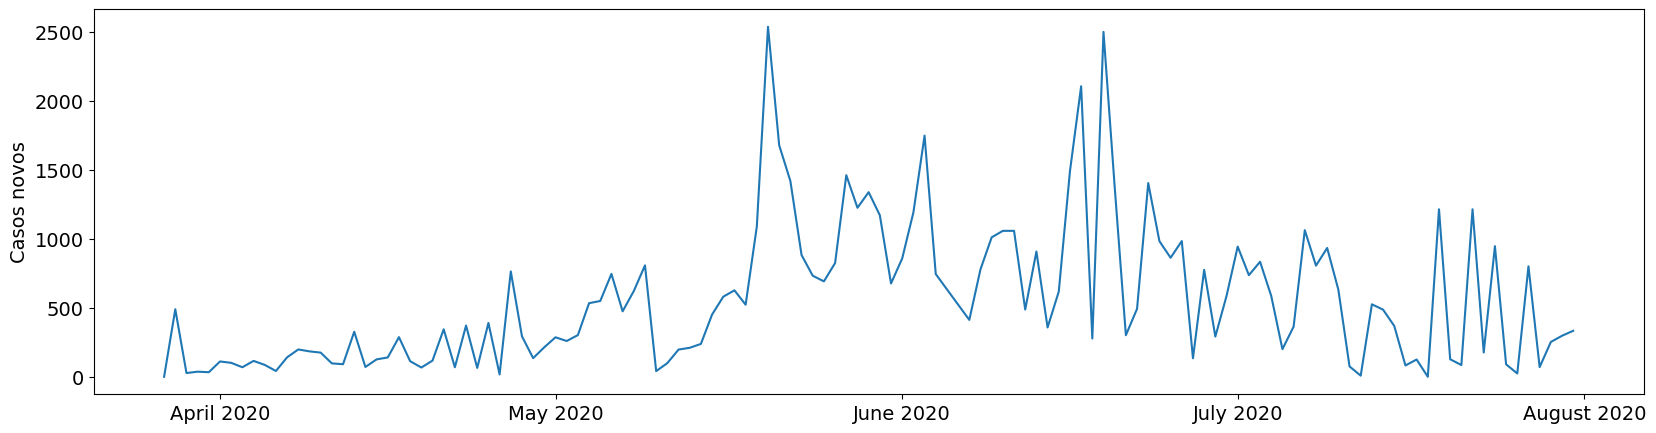

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.functions import vector_to_array
from pyspark.sql import functions as F


def apply_z_score(df, limite_comum=1):
    assembler = VectorAssembler(inputCols=["casos_novos"], outputCol="casos_novos_vec")
    scaler = StandardScaler(
        inputCol="casos_novos_vec",
        outputCol="casos_novos_scaled",
        withStd=True,
        withMean=True,
    )

    pipeline = Pipeline(stages=[assembler, scaler])
    model = pipeline.fit(df)
    df_scaled = model.transform(df)

    z_scored_df = (
        df_scaled.withColumn("z_score_arr", vector_to_array(F.col("casos_novos_scaled")))  # correct extraction
        .withColumn("z_score", F.col("z_score_arr").getItem(0))
        .filter(F.abs(F.col("z_score")) < limite_comum)
        .drop("casos_novos_vec", "casos_novos_scaled")
    )

    return z_scored_df


z_scored_df = apply_z_score(rio_df)
plot(z_scored_df)